# RehabModel

This notebook loads the combined data, and models the mortality rate.

In [1]:
%matplotlib inline

import json
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import psycopg2
from sklearn import ensemble
from sklearn import linear_model
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
import scipy as sp
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database

/Users/gkafka/anaconda/envs/insight/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
with open('DataCombined.json', 'r') as f:
    d = json.load(f);

df = pd.DataFrame(d);
df.index = df.index.astype(int);
df.sort_index(inplace=True);
print df.dtypes
df.head()

County                                                           object
Death Rate Category Median                                      float64
Estimated Age-adjusted Death Rate, 11 Categories (in ranges)     object
FIPS                                                            float64
FIPS State                                                      float64
Opioid Claims                                                   float64
Opioid Prescribing Rate                                         float64
Overall Claims                                                  float64
Part D Prescribers                                              float64
Population                                                      float64
ST                                                               object
State                                                            object
Year                                                            float64
n_facilities                                                    

,County,Death Rate Category Median,"Estimated Age-adjusted Death Rate, 11 Categories (in ranges)",FIPS,FIPS State,Opioid Claims,Opioid Prescribing Rate,Overall Claims,Part D Prescribers,Population,ST,State,Year,n_facilities
14,autauga county,11.0,10.1-12,1001.0,1.0,20482.0,9.803002,208936.0,67.0,55136.0,AL,Alabama,2013.0,0.0
15,autauga county,11.0,10.1-12,1001.0,1.0,20355.0,9.724810,209310.0,67.0,55395.0,AL,Alabama,2014.0,0.0
30,baldwin county,19.0,18.1-20,1003.0,1.0,82517.0,9.151229,901704.0,407.0,195443.0,AL,Alabama,2013.0,16.0
31,baldwin county,19.0,18.1-20,1003.0,1.0,81866.0,9.052919,904305.0,425.0,200111.0,AL,Alabama,2014.0,16.0
46,barbour county,7.0,6.1-8,1005.0,1.0,8935.0,6.278679,142307.0,33.0,26978.0,AL,Alabama,2013.0,0.0


In [3]:
df['Death Rate Category Median'] = df['Death Rate Category Median'].astype(int);
df['FIPS'] = df['FIPS'].astype(int);
df['FIPS'] = df['FIPS'].astype(str);
df['FIPS State'] = df['FIPS State'].astype(int);
df['Opioid Claims'] = df['Opioid Claims'].astype(int);
df['Overall Claims'] = df['Overall Claims'].astype(int);
df['Part D Prescribers'] = df['Part D Prescribers'].astype(int);
df['Population'] = df['Population'].astype(int);
df['Year'] = df['Year'].astype(int);
df['n_facilities'] = df['n_facilities'].astype(int);
df.rename(columns={'Estimated Age-adjusted Death Rate, 11 Categories (in ranges)':
                   'Estimated Age Adjusted Death Rate'}, inplace=True)
columns = [column.replace(' ','_').lower() for column in df.columns];
df.columns = columns;
print df.dtypes

county                                object
death_rate_category_median             int64
estimated_age_adjusted_death_rate     object
fips                                  object
fips_state                             int64
opioid_claims                          int64
opioid_prescribing_rate              float64
overall_claims                         int64
part_d_prescribers                     int64
population                             int64
st                                    object
state                                 object
year                                   int64
n_facilities                           int64
dtype: object


In [4]:
fixcounty = lambda w: w.rsplit(' ', 1)[0];
df['county'] = df['county'].apply(fixcounty);

def fixfips(f):
    if len(f) == 4:
        return "0"+f;
    return f;
df['fips'] = df['fips'].apply(fixfips)

df['facility_density'] = df['n_facilities'].values/df['population'];
df.head()

,county,death_rate_category_median,estimated_age_adjusted_death_rate,fips,fips_state,opioid_claims,opioid_prescribing_rate,overall_claims,part_d_prescribers,population,st,state,year,n_facilities,facility_density
14,autauga,11,10.1-12,01001,1,20482,9.803002,208936,67,55136,AL,Alabama,2013,0,0.000000
15,autauga,11,10.1-12,01001,1,20355,9.724810,209310,67,55395,AL,Alabama,2014,0,0.000000
30,baldwin,19,18.1-20,01003,1,82517,9.151229,901704,407,195443,AL,Alabama,2013,16,0.000082
31,baldwin,19,18.1-20,01003,1,81866,9.052919,904305,425,200111,AL,Alabama,2014,16,0.000080
46,barbour,7,6.1-8,01005,1,8935,6.278679,142307,33,26978,AL,Alabama,2013,0,0.000000


In [5]:
df_trim = df.copy();

cols_to_use = ['opioid_claims', 'opioid_prescribing_rate',
               'part_d_prescribers', 'population', 'n_facilities'];

df_trim.head()

,county,death_rate_category_median,estimated_age_adjusted_death_rate,fips,fips_state,opioid_claims,opioid_prescribing_rate,overall_claims,part_d_prescribers,population,st,state,year,n_facilities,facility_density
14,autauga,11,10.1-12,01001,1,20482,9.803002,208936,67,55136,AL,Alabama,2013,0,0.000000
15,autauga,11,10.1-12,01001,1,20355,9.724810,209310,67,55395,AL,Alabama,2014,0,0.000000
30,baldwin,19,18.1-20,01003,1,82517,9.151229,901704,407,195443,AL,Alabama,2013,16,0.000082
31,baldwin,19,18.1-20,01003,1,81866,9.052919,904305,425,200111,AL,Alabama,2014,16,0.000080
46,barbour,7,6.1-8,01005,1,8935,6.278679,142307,33,26978,AL,Alabama,2013,0,0.000000


In [6]:
x_train = df_trim[df_trim['year'] == 2013];
x_train = x_train[x_train['n_facilities'] > 0];
y_train = x_train['death_rate_category_median'];
x_train = x_train[cols_to_use];
#ss = StandardScaler().fit(x_train);
#ss.transform(x_train);

x_test  = df_trim[df_trim['year'] == 2014];
x_test  = x_test[x_test['n_facilities'] > 0];
y_test  = x_test['death_rate_category_median'];
x_test  = x_test[cols_to_use];
#ss.transform(x_test);

In [9]:
lr = linear_model.LinearRegression();
lr.fit(x_train[cols_to_use], y_train);
print lr.coef_;
print lr.score(x_train[cols_to_use], y_train);

pred_train = lr.predict(x_train[cols_to_use]);
pred_test = lr.predict(x_test[cols_to_use]);

bins = np.linspace(0,20,11);
bins = np.append(bins, 100);
digitized = 2*np.digitize(pred_test, bins)-1
print np.sqrt(metrics.mean_squared_error(y_test, digitized))
print np.sqrt(np.var(y_test))

[  1.44807071e-05   1.14719368e+00   5.18773692e-04  -3.80651652e-06
   1.65492749e-02]
0.202215279053
4.49421319237
4.84248025517


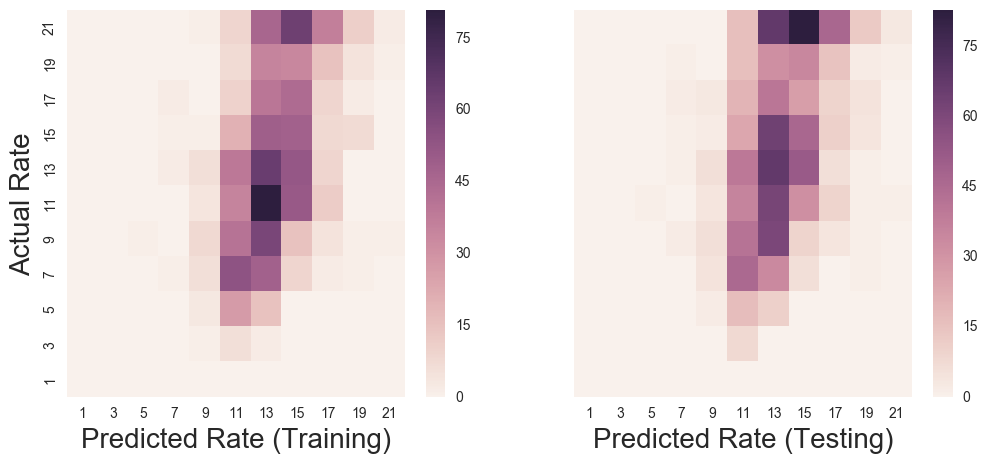

In [10]:
h2train, xe, ye = np.histogram2d(pred_train, y_train,
                             bins=[xrange(0,24,2), xrange(0,24,2)])
h2train = h2train.transpose()
h2test, xe, ye = np.histogram2d(pred_test, y_test,
                             bins=[xrange(0,24,2), xrange(0,24,2)])
h2test = h2test.transpose()

fig, [axL, axR] = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharex=True, sharey=True);
sns.heatmap(h2train, xticklabels=range(1,23,2), yticklabels=range(1,23,2), ax=axL)
axL.invert_yaxis()
axL.set_xlabel('Predicted Rate (Training)');
axL.xaxis.label.set_fontsize(20);
axL.set_xlim(0,22);
axL.set_ylabel('Actual Rate');
axL.yaxis.label.set_fontsize(20);

sns.heatmap(h2test, xticklabels=range(1,23,2), yticklabels=range(1,23,2), ax=axR)
axR.invert_yaxis()
axR.set_xlabel('Predicted Rate (Testing)');
axR.xaxis.label.set_fontsize(20);

plt.savefig('Fit_LR.png')

In [11]:
rf = ensemble.RandomForestRegressor();
rf.fit(x_train[cols_to_use], y_train);
print rf.feature_importances_;

pred_train = rf.predict(x_train[cols_to_use]);
pred_test = rf.predict(x_test[cols_to_use]);

bins = np.linspace(0,20,11);
bins = np.append(bins, 100);
digitized = 2*np.digitize(pred_test, bins)-1
print np.sqrt(metrics.mean_squared_error(y_test, digitized))
print np.sqrt(np.var(y_test))

[ 0.18224778  0.39757889  0.15502743  0.19200925  0.07313665]
3.78473672557
4.84248025517


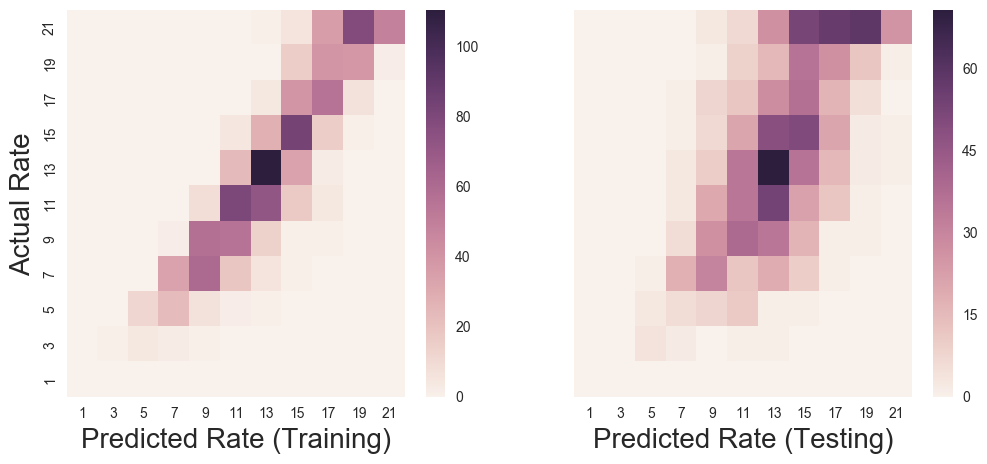

In [26]:
h2train, xe, ye = np.histogram2d(pred_train, y_train,
                             bins=[xrange(0,24,2), xrange(0,24,2)])
h2train = h2train.transpose()
h2test, xe, ye = np.histogram2d(pred_test, y_test,
                             bins=[xrange(0,24,2), xrange(0,24,2)])
h2test = h2test.transpose()

fig, [axL, axR] = plt.subplots(nrows=1, ncols=2, figsize=(12,5), sharex=True, sharey=True);
sns.heatmap(h2train, xticklabels=range(1,23,2), yticklabels=range(1,23,2), ax=axL)
axL.invert_yaxis()
axL.set_xlabel('Predicted Rate (Training)');
axL.xaxis.label.set_fontsize(20);
axL.set_xlim(0,22);
axL.set_ylabel('Actual Rate');
axL.yaxis.label.set_fontsize(20);

sns.heatmap(h2test, xticklabels=range(1,23,2), yticklabels=range(1,23,2), ax=axR)
axR.invert_yaxis()
axR.set_xlabel('Predicted Rate (Testing)');
axR.xaxis.label.set_fontsize(20);

plt.savefig('Fit_RF.png')

In [11]:
df_trim['pred_diff'] = df_trim['death_rate_category_median'].values - rf.predict(df_trim[cols_to_use])
df_trim.head()

,county,death_rate_category_median,estimated_age_adjusted_death_rate,fips,fips_state,opioid_claims,opioid_prescribing_rate,overall_claims,part_d_prescribers,population,st,state,year,n_facilities,facility_density,pred_diff
14,autauga,11,10.1-12,01001,1,20482,9.803002,208936,67,55136,AL,Alabama,2013,0,0.000000,-7.8
15,autauga,11,10.1-12,01001,1,20355,9.724810,209310,67,55395,AL,Alabama,2014,0,0.000000,-7.8
30,baldwin,19,18.1-20,01003,1,82517,9.151229,901704,407,195443,AL,Alabama,2013,16,0.000082,-0.2
31,baldwin,19,18.1-20,01003,1,81866,9.052919,904305,425,200111,AL,Alabama,2014,16,0.000080,0.6
46,barbour,7,6.1-8,01005,1,8935,6.278679,142307,33,26978,AL,Alabama,2013,0,0.000000,-4.6


In [12]:
joblib.dump(rf, 'RehabApp/static/model_rf.pkl')
#joblib.dump(ss, 'RehabApp/static/scale.pkl')

['RehabApp/static/model_rf.pkl',
 'RehabApp/static/model_rf.pkl_01.npy',
 'RehabApp/static/model_rf.pkl_02.npy',
 'RehabApp/static/model_rf.pkl_03.npy',
 'RehabApp/static/model_rf.pkl_04.npy',
 'RehabApp/static/model_rf.pkl_05.npy',
 'RehabApp/static/model_rf.pkl_06.npy',
 'RehabApp/static/model_rf.pkl_07.npy',
 'RehabApp/static/model_rf.pkl_08.npy',
 'RehabApp/static/model_rf.pkl_09.npy',
 'RehabApp/static/model_rf.pkl_10.npy',
 'RehabApp/static/model_rf.pkl_11.npy',
 'RehabApp/static/model_rf.pkl_12.npy',
 'RehabApp/static/model_rf.pkl_13.npy',
 'RehabApp/static/model_rf.pkl_14.npy',
 'RehabApp/static/model_rf.pkl_15.npy',
 'RehabApp/static/model_rf.pkl_16.npy',
 'RehabApp/static/model_rf.pkl_17.npy',
 'RehabApp/static/model_rf.pkl_18.npy',
 'RehabApp/static/model_rf.pkl_19.npy',
 'RehabApp/static/model_rf.pkl_20.npy',
 'RehabApp/static/model_rf.pkl_21.npy',
 'RehabApp/static/model_rf.pkl_22.npy',
 'RehabApp/static/model_rf.pkl_23.npy',
 'RehabApp/static/model_rf.pkl_24.npy',
 'Rehab

In [13]:
dbname = 'rehab_db';
username = 'gkafka';

engine = create_engine('postgres://{0}@localhost/{1}'.format(username,dbname));
print engine.url;

if not database_exists(engine.url):
    create_database(engine.url);
print database_exists(engine.url);

df_trim.to_sql('rehab_table', engine, if_exists='replace')

postgres://gkafka@localhost/rehab_db
True


In [14]:
con = None
con = psycopg2.connect(database = dbname, user = username)

# query:
sql_query = """
SELECT * FROM rehab_table WHERE year=2013 AND st='TX';
"""
birth_data_from_sql = pd.read_sql_query(sql_query,con)

birth_data_from_sql.head()

,index,county,death_rate_category_median,estimated_age_adjusted_death_rate,fips,fips_state,opioid_claims,opioid_prescribing_rate,overall_claims,part_d_prescribers,population,st,state,year,n_facilities,facility_density,pred_diff
0,16262,crane,11,10.1-12,48103,48,713,5.665475,12585,6,4755,TX,Texas,2013,0,0.0,-4.2
1,40390,anderson,15,14.1-16,48001,48,13497,5.628440,239800,93,57934,TX,Texas,2013,0,0.0,2.0
2,40406,andrews,11,10.1-12,48003,48,2651,5.810029,45628,27,16808,TX,Texas,2013,0,0.0,-5.2
3,40422,angelina,9,8.1-10,48005,48,35022,5.246977,667470,220,87613,TX,Texas,2013,0,0.0,-4.2
4,40438,aransas,21,>20,48007,48,5245,5.636209,93059,54,24229,TX,Texas,2013,0,0.0,10.4


In [16]:
csv_cols = ['fips', 'county', 'st', 'pred_diff']
def caps_county(c):
    return ' '.join(w.title() for w in c.split(' '))
dfcsv = df_trim[df_trim['year'] == 2014][csv_cols].copy()
dfcsv['county'] = dfcsv['county'].apply(caps_county)
dfcsv.to_csv('RehabApp/static/rehab.csv')
dfcsv.head()

,fips,county,st,pred_diff
15,01001,Autauga,AL,-7.8
31,01003,Baldwin,AL,0.6
47,01005,Barbour,AL,-4.6
63,01007,Bibb,AL,5.6
79,01009,Blount,AL,-1.2
